Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Choose which observations you will use to train, validate, and test your model. And which observations, if any, to exclude.
- [ ] Determine whether your problem is regression or classification.
- [ ] Choose your evaluation metric.
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" information from the future?


In [1]:
import pandas as pd

df = pd.read_csv('assists-data-01.csv')
print(df.shape)
df.head()

(22954, 32)


,Player,Year,Lge,Pos,Age,Tm,G,GS,MP,FG,...,ORB,DRB,TRB,STL,BLK,TOV,PF,PTS,AST,Target
0,A.C. Green,1986.0,NBA,PF,22.0,LAL,82.0,1.0,18.8,2.5,...,2.0,2.7,4.6,0.6,0.6,1.2,2.8,6.4,0.7,1.1
1,A.C. Green,1987.0,NBA,PF,23.0,LAL,79.0,72.0,28.4,4.0,...,2.7,5.1,7.8,0.9,1.0,1.3,2.2,10.8,1.1,1.1
2,A.C. Green,1988.0,NBA,PF,24.0,LAL,82.0,64.0,32.1,3.9,...,3.0,5.7,8.7,1.1,0.5,1.5,2.5,11.4,1.1,1.3
3,A.C. Green,1989.0,NBA,PF,25.0,LAL,82.0,82.0,30.6,4.9,...,3.1,5.9,9.0,1.1,0.7,1.5,2.1,13.3,1.3,1.1
4,A.C. Green,1990.0,NBA,PF,26.0,LAL,82.0,82.0,33.0,4.7,...,3.2,5.5,8.7,0.8,0.6,1.4,2.5,12.9,1.1,0.9


### Choose your target. Which column in your tabular dataset will you predict?

Answer: As you can see above, I already engineered my target yesterday. I sorted the data by player and year, and moved each player's "Assists" number up one. In other words, each row of this dataset (including the "Year" column) can be interpreted as the player's performance data from the *previous* year, and the "Target" column is their assist number for the *current* year.

For now, I'll try to predict their assists purely using these box score metrics.

### Choose which observations you will use to train, validate, and test your model. And which observations, if any, to exclude.

In [2]:
df['Target'].isnull().sum() # These are the rows for the player's final season in the league.
# I can't use their stats for this season to predict their assist rate next season, because they don't have a next season!
# While I may end up using some data from here later (e.g. I want to get the field goal percentage for all of a player's
# teammates), for the time being I'll exclude it.
# (This also, obviously, includes all data from the 2018-2019 season.)

4625

In [3]:
df2 = df.dropna(subset=['Target'])
print(df2.shape)
df2['Target'].isnull().sum()

(18329, 32)


0

In [4]:
# I'll train/val/test split by year.
# Once I get a final model, though, I'm going to apply it to the entire dataset to get predictions for the 2019-2020 season.

test = df2[df2['Year'] == 2018]
temp = df2[df2['Year'] < 2018]
val = temp[temp['Year'] >= 2015]
train = temp[temp['Year'] < 2015]

test = test.reset_index(drop=True)
val = val.reset_index(drop=True)
train = train.reset_index(drop=True)

train.shape, val.shape, test.shape

((16705, 32), (1212, 32), (412, 32))

In [5]:
assert train.shape[0] + val.shape[0] + test.shape[0] == df2.shape[0]

### Determine whether your problem is regression or classification.

Answer: It's regression.

### Choose your evaluation metric.

Answer: I found this good article on regression metrics -- https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4

I'm thinking MAE (while also calculating the R^2 score).

### Begin to clean and explore your data.

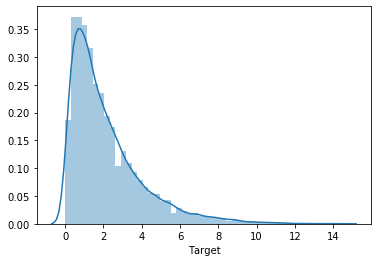

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.distplot(df2['Target']); # Skewed left, but not overly so.

In [6]:
pd.set_option('display.max_columns', 100)

train.describe()

,Year,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,STL,BLK,TOV,PF,PTS,AST,Target
count,16705.000000,16703.000000,16705.000000,11474.000000,16253.000000,16705.000000,16705.000000,16685.000000,12696.000000,12696.000000,10930.000000,16705.000000,16705.000000,16680.000000,16685.000000,16705.000000,16705.000000,16541.000000,13875.000000,13875.000000,16336.000000,13366.000000,13367.000000,13160.000000,16705.000000,16705.000000,16705.000000,16705.000000
mean,1989.593834,26.343351,61.910685,31.109726,23.142115,3.773732,8.371152,0.443736,0.375173,1.091359,0.241620,3.487501,7.540503,0.455823,0.461085,2.016851,2.707106,0.727412,1.262004,2.862386,4.367207,0.769662,0.482397,1.480038,2.279395,9.848728,2.171727,2.149129
std,16.999329,3.655913,21.300058,30.550818,10.042682,2.384154,4.992178,0.072916,0.566222,1.499274,0.171312,2.333646,4.817477,0.074416,0.074404,1.572086,2.002637,0.118767,0.952075,1.940331,3.052716,0.503766,0.565972,0.858596,0.865109,6.269730,1.893814,1.896042
min,1947.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1977.000000,24.000000,51.000000,2.000000,15.000000,1.900000,4.300000,0.409000,0.000000,0.000000,0.087000,1.700000,3.700000,0.423000,0.428000,0.800000,1.200000,0.669000,0.500000,1.500000,2.200000,0.400000,0.100000,0.800000,1.700000,4.900000,0.800000,0.800000
50%,1992.000000,26.000000,70.000000,19.000000,23.200000,3.300000,7.500000,0.447000,0.100000,0.300000,0.285000,3.000000,6.500000,0.462000,0.469000,1.600000,2.200000,0.747000,1.000000,2.400000,3.600000,0.700000,0.300000,1.300000,2.300000,8.600000,1.600000,1.600000
75%,2004.000000,29.000000,79.000000,62.000000,31.700000,5.200000,11.600000,0.485000,0.600000,1.800000,0.360000,4.800000,10.500000,0.497000,0.503000,2.800000,3.700000,0.806000,1.800000,3.800000,5.800000,1.000000,0.600000,2.000000,2.900000,13.700000,2.900000,2.900000
max,2014.000000,42.000000,90.000000,83.000000,48.500000,20.000000,39.500000,1.000000,3.500000,8.700000,1.000000,20.000000,39.500000,1.000000,1.000000,11.500000,17.000000,1.000000,7.200000,13.700000,27.200000,3.700000,5.600000,5.700000,6.000000,50.400000,14.500000,14.500000


In [7]:
train.isnull().sum()

Player       0
Year         0
Lge          0
Pos          0
Age          2
Tm           0
G            0
GS        5231
MP         452
FG           0
FGA          0
FG%         20
3P        4009
3PA       4009
3P%       5775
2P           0
2PA          0
2P%         25
eFG%        20
FT           0
FTA          0
FT%        164
ORB       2830
DRB       2830
TRB        369
STL       3339
BLK       3338
TOV       3545
PF           0
PTS          0
AST          0
Target       0
dtype: int64

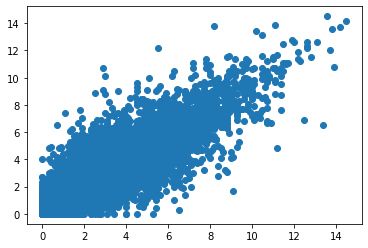

In [40]:
from sklearn.metrics import mean_absolute_error

plt.scatter(train['AST'], train['Target'])
plt.show()

In [9]:
# The baseline prediction is that each player will have the same number of assists as they did the previous year.

baseline = train['AST']

mean_absolute_error(baseline, train['Target'])

# A pretty low baseline error...it might be hard to get an improvement on it.

0.6609697695300809

In [10]:
mean_absolute_error(val['AST'], val['Target'])

0.6183168316831683

In [11]:
mean_absolute_error(test['AST'], test['Target'])

0.6764563106796116

In [12]:
train.columns

Index(['Player', 'Year', 'Lge', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'AST', 'Target'],
      dtype='object')

In [13]:
train.loc[0, 'Player']

'A.C. Green'

In [14]:
train.index

RangeIndex(start=0, stop=16705, step=1)

In [15]:
# Three-pointers didn't exist in the NBA before 1980, so I'll replace those NaNs with 0.

new_3P = []
new_3PA = []
new_3PP = []

for i in range(len(train)):
    if train.loc[i, 'Lge'] == 'ABA':
        new_3P.append(train.loc[i, '3P'])
        new_3PA.append(train.loc[i, '3PA'])
        new_3PP.append(train.loc[i, '3P%'])
    elif train.loc[i, 'Year'] >= 1980:
        new_3P.append(train.loc[i, '3P'])
        new_3PA.append(train.loc[i, '3PA'])
        new_3PP.append(train.loc[i, '3P%'])
    else:
        new_3P.append(0)
        new_3PA.append(0)
        new_3PP.append(0)

train['3P'] = new_3P
train['3PA'] = new_3PA
train['3P%'] = new_3PP

train.isnull().sum()

Player       0
Year         0
Lge          0
Pos          0
Age          2
Tm           0
G            0
GS        5231
MP         452
FG           0
FGA          0
FG%         20
3P           0
3PA          0
3P%       1766
2P           0
2PA          0
2P%         25
eFG%        20
FT           0
FTA          0
FT%        164
ORB       2830
DRB       2830
TRB        369
STL       3339
BLK       3338
TOV       3545
PF           0
PTS          0
AST          0
Target       0
dtype: int64

In [16]:
train.head()

,Player,Year,Lge,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,STL,BLK,TOV,PF,PTS,AST,Target
0,A.C. Green,1986.0,NBA,PF,22.0,LAL,82.0,1.0,18.8,2.5,4.7,0.539,0.0,0.1,0.167,2.5,4.7,0.545,0.540,1.2,2.0,0.611,2.0,2.7,4.6,0.6,0.6,1.2,2.8,6.4,0.7,1.1
1,A.C. Green,1987.0,NBA,PF,23.0,LAL,79.0,72.0,28.4,4.0,7.4,0.538,0.0,0.1,0.000,4.0,7.4,0.543,0.538,2.8,3.6,0.780,2.7,5.1,7.8,0.9,1.0,1.3,2.2,10.8,1.1,1.1
2,A.C. Green,1988.0,NBA,PF,24.0,LAL,82.0,64.0,32.1,3.9,7.8,0.503,0.0,0.0,0.000,3.9,7.8,0.505,0.503,3.6,4.6,0.773,3.0,5.7,8.7,1.1,0.5,1.5,2.5,11.4,1.1,1.3
3,A.C. Green,1989.0,NBA,PF,25.0,LAL,82.0,82.0,30.6,4.9,9.2,0.529,0.0,0.2,0.235,4.8,9.0,0.536,0.532,3.4,4.4,0.786,3.1,5.9,9.0,1.1,0.7,1.5,2.1,13.3,1.3,1.1
4,A.C. Green,1990.0,NBA,PF,26.0,LAL,82.0,82.0,33.0,4.7,9.8,0.478,0.2,0.6,0.283,4.5,9.3,0.489,0.486,3.4,4.5,0.751,3.2,5.5,8.7,0.8,0.6,1.4,2.5,12.9,1.1,0.9


In [38]:
# After beating my head against the wall a bit, I realized the NaN values in FG%, 3P%, 2P%, eFG%, and FT% are when the
# denominator in their respective formulas is 0--i.e., when the player didn't take any of the respective shots.
# In these cases, I think it makes the most sense to set these values to 0.

train = train.fillna(value={'FG%': 0, '3P%': 0, '2P%': 0, 'eFG%': 0, 'FT%': 0})
train.isnull().sum()

Player       0
Year         0
Lge          0
Pos          0
Age          2
Tm           0
G            0
GS        5231
MP         452
FG           0
FGA          0
FG%          0
3P           0
3PA          0
3P%          0
2P           0
2PA          0
2P%          0
eFG%         0
FT           0
FTA          0
FT%          0
ORB       2830
DRB       2830
TRB        369
STL       3339
BLK       3338
TOV       3545
PF           0
PTS          0
AST          0
Target       0
dtype: int64

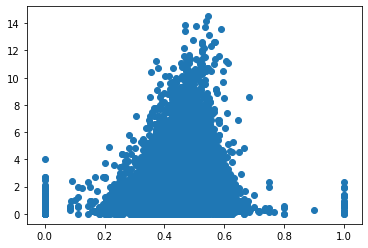

In [41]:
plt.scatter(train['eFG%'], train['Target'])
plt.show()

# This is pretty interesting...it's a normal distribution! It looks like the most assists happen
# when the player has an eFG% a little above 50%.

### Begin to choose which features, if any, to exclude. Would some features "leak" information from the future?

Answer: From how I set the data up, I don't think any features leak future information. Every row is limited to a specific year, and the Target column is always data from the *following* year. But I will have to be careful about this if I add more features.

As for choosing features to exclude...

In [42]:
train.columns

Index(['Player', 'Year', 'Lge', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'AST', 'Target'],
      dtype='object')

I'll generally keep the 'Player' column for tracking purposes, but I'll exclude it when I run the actual model. Otherwise I don't see any obvious candidates for exclusion. Maybe I don't need both offensive rebounds and defensive rebounds when I have total rebounds, especially since those columns have a lot of NaNs.

### More cleaning...

In [46]:
train.isnull().sum()

Player       0
Year         0
Lge          0
Pos          0
Age          2
Tm           0
G            0
GS        5231
MP         452
FG           0
FGA          0
FG%          0
3P           0
3PA          0
3P%          0
2P           0
2PA          0
2P%          0
eFG%         0
FT           0
FTA          0
FT%          0
ORB       2830
DRB       2830
TRB        369
STL       3339
BLK       3338
TOV       3545
PF           0
PTS          0
AST          0
Target       0
dtype: int64

In [48]:
age_null = train[pd.isna(train['Age']) == True]
age_null.head()

,Player,Year,Lge,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,STL,BLK,TOV,PF,PTS,AST,Target
1724,Bob Schafer,1956.0,NBA,SG,NaN,TOT,54.0,NaN,10.7,1.5,5.0,0.300,0.0,0.0,0.0,1.5,5.0,0.300,0.30,1.1,1.5,0.765,NaN,NaN,1.3,NaN,NaN,NaN,1.4,4.1,1.0,1.4
1840,Bobby Wilson,1968.0,ABA,PF,NaN,DLC,69.0,NaN,22.6,3.3,8.4,0.389,0.0,0.0,0.5,3.3,8.4,0.389,0.39,2.4,3.8,0.615,NaN,NaN,6.5,NaN,NaN,1.8,3.0,8.9,0.8,0.8


I looked up both these players on Wikipedia to get their ages.

In [50]:
train = train.fillna(value={'Age': 23}, limit=1)
train = train.fillna(value={'Age': 24}, limit=1)

train.isnull().sum()

Player       0
Year         0
Lge          0
Pos          0
Age          0
Tm           0
G            0
GS        5231
MP         452
FG           0
FGA          0
FG%          0
3P           0
3PA          0
3P%          0
2P           0
2PA          0
2P%          0
eFG%         0
FT           0
FTA          0
FT%          0
ORB       2830
DRB       2830
TRB        369
STL       3339
BLK       3338
TOV       3545
PF           0
PTS          0
AST          0
Target       0
dtype: int64

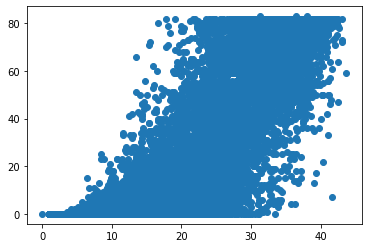

In [63]:
# Next is "games started." I have an idea for this.

A = train.dropna(subset=['GS', 'MP'])

plt.scatter(A['MP'], A['GS']);

# There is a correlation!

In [64]:
# I'll make a model to predict games started.

A = A.drop(['Player', 'Tm', 'Target'], axis=1)

X_train = A.drop('GS', axis=1)
y_train = A['GS']

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
    'selectkbest__k': range(1, len(X_train.columns)+1),
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train);

C:\Users\David\Documents\Python_Stuff\envs\unit3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 84 is smaller than n_iter=100. Running 84 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   10.5s
[Paralle

In [66]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation mae', search.best_score_)

Best hyperparameters {'simpleimputer__strategy': 'mean', 'selectkbest__k': 28}
Cross-validation mae -12.321071019918644


In [69]:
mean_absolute_error([np.mean(A['GS'])] * len(A), A['GS'])

# Model is better than the baseline.

27.641402746724268

In [70]:
B = train[pd.isna(train['GS']) == True]
B.head()

,Player,Year,Lge,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,STL,BLK,TOV,PF,PTS,AST,Target
35,Aaron James,1975.0,NBA,SF,22.0,NOJ,76.0,NaN,22.8,4.9,10.2,0.477,0.0,0.0,0.0,4.9,10.2,0.477,0.477,1.9,2.5,0.778,1.8,3.0,4.8,0.5,0.2,NaN,2.9,11.7,0.9,0.8
36,Aaron James,1976.0,NBA,SF,23.0,NOJ,75.0,NaN,17.9,3.5,7.9,0.441,0.0,0.0,0.0,3.5,7.9,0.441,0.441,2.0,2.7,0.750,1.2,2.1,3.3,0.4,0.1,NaN,2.3,9.0,0.8,1.1
37,Aaron James,1977.0,NBA,SF,24.0,NOJ,52.0,NaN,20.4,4.6,9.3,0.490,0.0,0.0,0.0,4.6,9.3,0.490,0.490,1.7,2.2,0.781,1.1,2.5,3.6,0.4,0.1,NaN,2.4,10.9,1.1,1.4
38,Aaron James,1978.0,NBA,SF,25.0,NOJ,80.0,NaN,26.5,5.4,10.8,0.497,0.0,0.0,0.0,5.4,10.8,0.497,0.497,1.5,2.0,0.745,2.0,3.2,5.3,0.5,0.3,1.6,3.2,12.2,1.4,1.1
64,Abdul Jeelani,1980.0,NBA,SF,25.0,POR,77.0,NaN,16.7,3.7,7.3,0.510,0.0,0.1,0.0,3.7,7.3,0.515,0.510,2.1,2.6,0.789,1.5,2.0,3.5,0.5,0.5,1.5,2.0,9.6,1.2,1.0


In [73]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    SelectKBest(f_regression, k=28),
    LinearRegression()
)

pipeline.fit(X_train, y_train)

X_pred = B.drop(['Player', 'Tm', 'Target', 'GS'], axis=1)

y_pred = np.around(pipeline.predict(X_pred))

B['GS'] = y_pred

B.head()

C:\Users\David\Documents\Python_Stuff\envs\unit3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\David\Documents\Python_Stuff\envs\unit3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\David\Documents\Python_Stuff\envs\unit3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\David\Documents\Python_Stuff\envs\unit3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\David\Documents\Python_Stuff\envs\unit3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

,Player,Year,Lge,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,STL,BLK,TOV,PF,PTS,AST,Target
35,Aaron James,1975.0,NBA,SF,22.0,NOJ,76.0,36.0,22.8,4.9,10.2,0.477,0.0,0.0,0.0,4.9,10.2,0.477,0.477,1.9,2.5,0.778,1.8,3.0,4.8,0.5,0.2,NaN,2.9,11.7,0.9,0.8
36,Aaron James,1976.0,NBA,SF,23.0,NOJ,75.0,22.0,17.9,3.5,7.9,0.441,0.0,0.0,0.0,3.5,7.9,0.441,0.441,2.0,2.7,0.750,1.2,2.1,3.3,0.4,0.1,NaN,2.3,9.0,0.8,1.1
37,Aaron James,1977.0,NBA,SF,24.0,NOJ,52.0,26.0,20.4,4.6,9.3,0.490,0.0,0.0,0.0,4.6,9.3,0.490,0.490,1.7,2.2,0.781,1.1,2.5,3.6,0.4,0.1,NaN,2.4,10.9,1.1,1.4
38,Aaron James,1978.0,NBA,SF,25.0,NOJ,80.0,48.0,26.5,5.4,10.8,0.497,0.0,0.0,0.0,5.4,10.8,0.497,0.497,1.5,2.0,0.745,2.0,3.2,5.3,0.5,0.3,1.6,3.2,12.2,1.4,1.1
64,Abdul Jeelani,1980.0,NBA,SF,25.0,POR,77.0,23.0,16.7,3.7,7.3,0.510,0.0,0.1,0.0,3.7,7.3,0.515,0.510,2.1,2.6,0.789,1.5,2.0,3.5,0.5,0.5,1.5,2.0,9.6,1.2,1.0


In [75]:
new_gs = []

for i in range(len(train)):
    if (i in B.index) == False:
        new_gs.append(train.loc[i, 'GS'])
    else:
        new_gs.append(B.loc[i, 'GS'])
        
assert new_gs[0] == train.loc[0, 'GS']

In [77]:
assert new_gs[35] == B.loc[35, 'GS']

In [78]:
train['GS'] = new_gs

train.isnull().sum()

Player       0
Year         0
Lge          0
Pos          0
Age          0
Tm           0
G            0
GS           0
MP         452
FG           0
FGA          0
FG%          0
3P           0
3PA          0
3P%          0
2P           0
2PA          0
2P%          0
eFG%         0
FT           0
FTA          0
FT%          0
ORB       2830
DRB       2830
TRB        369
STL       3339
BLK       3338
TOV       3545
PF           0
PTS          0
AST          0
Target       0
dtype: int64

I think I'll just use SimpleImputer for the rest.

In [79]:
train.to_csv('train-01.csv', index=None, header=True)